## Importing Required Libraries

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from tensorflow.keras.optimizers import Adam
sns.set(style="darkgrid")

## Importing the Dataset

In [17]:
file_path = r"D:\\Paper Dataset\\K8 Reviews v0.2.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.shape)
df.head()

(14675, 2)


,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [18]:
df['sentiment'] = df['sentiment'].replace({1: 'positive', 0: 'negative'})
df['sentiment'] = df['sentiment'].astype(str)

In [19]:
df["sentiment"].value_counts()

sentiment
negative    7712
positive    6963
Name: count, dtype: int64

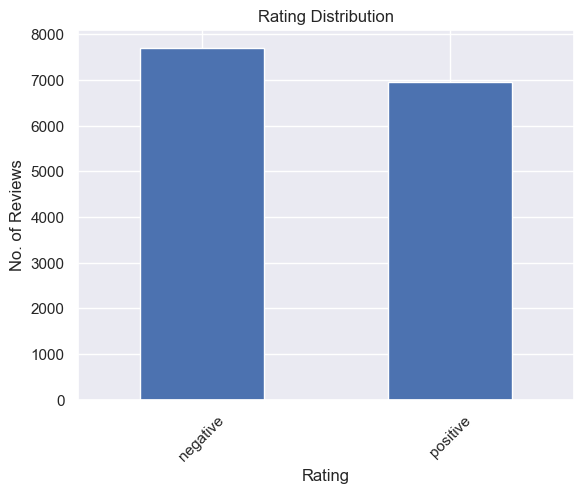

In [20]:
# Plot the value counts as a bar plot
df['sentiment'].value_counts().plot(kind='bar')

# Set the title and labels
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('No. of Reviews')

categories = df['sentiment'].value_counts().index  # Get the categories (which are the index of the value_counts Series)
custom_labels = [cat for cat in categories]  # Create custom labels
plt.xticks(ticks=range(len(categories)), labels=custom_labels, rotation=45)  # Set custom labels with rotation

# Show the plot
plt.show()

In [22]:
# Step 1: Create X and y
X = df['review']
y = pd.get_dummies(df['sentiment'])  # Step 2: One-hot encode y
y = y.astype(int)
y

,negative,positive
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
14670,0,1
14671,0,1
14672,0,1
14673,0,1


In [23]:
# Initial split: 80% for training, 20% for temporary dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary dataset equally into validation and test sets: 10% each of the original dataset
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and prepare the data for BERT
def encode_reviews(tokenizer, reviews, max_length):
    return tokenizer.batch_encode_plus(
        reviews,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=max_length,
        truncation = True,
        return_tensors='tf',
    )

# Choose a maximum sequence length for BERT
max_length = 256

# Encode the datasets
train_encodings = encode_reviews(tokenizer, X_train.tolist(), max_length)
val_encodings = encode_reviews(tokenizer, X_val.tolist(), max_length)
test_encodings = encode_reviews(tokenizer, X_test.tolist(), max_length)

C:\Users\Chetouani\anaconda3\envs\py310\lib\site-packages\transformers\tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model


# Load the pre-trained BERT model
bert = TFBertModel.from_pretrained('bert-base-uncased')

# Build the model
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
attention_masks = Input(shape=(max_length,), dtype='int32', name='attention_masks')

# Get the sequence output
sequence_output = bert(input_ids, attention_mask=attention_masks)[0]

# Select the first token's last hidden state
cls_token = sequence_output[:, 0, :]

# Add custom layers
x = Dense(512, activation='relu')(cls_token)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
output = Dense(y.shape[1], activation='softmax')(x)

# Compile the model
model = Model(inputs=[input_ids, attention_masks], outputs=output)

# Adjust the learning rate
optimizer = Adam(learning_rate=2e-5)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_save_path = r"D:\Marketing Paper\best_model_k8.h5"

checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([
        val_encodings['input_ids'], val_encodings['attention_mask']
    ], y_val),
    epochs=10,
    batch_size=16,  # Specify your desired batch size here
    callbacks=[checkpoint]
)


Epoch 1/10
734/734 [==============================] - 285s 336ms/step - loss: 0.3108 - accuracy: 0.8709 - val_loss: 0.2696 - val_accuracy: 0.8950
Epoch 2/10
734/734 [==============================] - 231s 315ms/step - loss: 0.2337 - accuracy: 0.9126 - val_loss: 0.2860 - val_accuracy: 0.8943
Epoch 3/10
734/734 [==============================] - 233s 317ms/step - loss: 0.1796 - accuracy: 0.9357 - val_loss: 0.3550 - val_accuracy: 0.8793
Epoch 4/10
734/734 [==============================] - 228s 310ms/step - loss: 0.1374 - accuracy: 0.9530 - val_loss: 0.3625 - val_accuracy: 0.8753
Epoch 5/10
734/734 [==============================] - 235s 320ms/step - loss: 0.1052 - accuracy: 0.9658 - val_loss: 0.4643 - val_accuracy: 0.8766
Epoch 6/10
734/734 [==============================] - 237s 323ms/step - loss: 0.0849 - accuracy: 0.9717 - val_loss: 0.5497 - val_accuracy: 0.8807
Epoch 7/10
734/734 [==============================] - 235s 320ms/step - loss: 0.0715 - accuracy: 0.9767 - val_loss: 0.6232 -

In [27]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model(model_save_path, custom_objects={'TFBertModel': TFBertModel})

# # Recompile the model with the optimizer, loss, and metrics
# model.compile(optimizer=Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(
    [test_encodings['input_ids'], test_encodings['attention_mask']],
    y_test
)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

46/46 [==============================] - 17s 189ms/step - loss: 0.2663 - accuracy: 0.9033
Test Loss: 0.26634666323661804, Test Accuracy: 0.9032697677612305


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming `test_encodings` is already prepared similar to `train_encodings` and `val_encodings`
predictions = best_model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])

# Assuming you have predictions from the model
predicted_class_indices = predictions.argmax(axis=1)

class_names = y_test.columns.tolist() 

# Convert y_test from one-hot encoding to class indices
true_class_indices = y_test.idxmax(axis=1).apply(class_names.index).values


# Generate the classification report using the true and predicted class indices
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_names)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)

# Calculate accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')

46/46 [==============================] - 15s 189ms/step
              precision    recall  f1-score   support

    negative       0.89      0.92      0.91       766
    positive       0.91      0.88      0.90       702

    accuracy                           0.90      1468
   macro avg       0.90      0.90      0.90      1468
weighted avg       0.90      0.90      0.90      1468

Accuracy for class negative: 0.92
Accuracy for class positive: 0.88
